# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial.

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

In [ ]:
We chose the airbnb dataset.

In [5]:
# Q1: Load and clean the Airbnb dataset

import pandas as pd
from pathlib import Path

# Load dataset
airbnb = pd.read_csv("/content/airbnb_hw.csv")

print("Raw shape:", airbnb.shape)
display(airbnb.head())
display(airbnb.info())
display(airbnb.isna().mean().sort_values(ascending=False).head(20))

# Drop exact duplicate rows
airbnb = airbnb.drop_duplicates()

# Drop columns with too many missing values (e.g. > 40%)
missing_frac = airbnb.isna().mean()
cols_to_drop = missing_frac[missing_frac > 0.40].index.tolist()
print("Dropping columns with >40% missing:", cols_to_drop)
airbnb = airbnb.drop(columns=cols_to_drop)

# Separate numeric & categorical columns
num_cols = airbnb.select_dtypes(include=["number"]).columns
cat_cols = airbnb.select_dtypes(exclude=["number"]).columns

# Fill numeric NAs with the median of each column
for col in num_cols:
    airbnb[col] = airbnb[col].fillna(airbnb[col].median())

# Fill categorical NAs with the mode (most frequent level)
for col in cat_cols:
    mode_val = airbnb[col].mode(dropna=True)
    if len(mode_val) > 0:
        airbnb[col] = airbnb[col].fillna(mode_val[0])
    else:
        airbnb = airbnb.drop(columns=[col])

print("Cleaned shape:", airbnb.shape)
display(airbnb.head())
print("Total missing after cleaning:", airbnb.isna().sum().sum())

Raw shape: (30478, 13)


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Host Id                     30478 non-null  int64  
 1   Host Since                  30475 non-null  object 
 2   Name                        30478 non-null  object 
 3   Neighbourhood               30478 non-null  object 
 4   Property Type               30475 non-null  object 
 5   Review Scores Rating (bin)  22155 non-null  float64
 6   Room Type                   30478 non-null  object 
 7   Zipcode                     30344 non-null  float64
 8   Beds                        30393 non-null  float64
 9   Number of Records           30478 non-null  int64  
 10  Number Of Reviews           30478 non-null  int64  
 11  Price                       30478 non-null  object 
 12  Review Scores Rating        22155 non-null  float64
dtypes: float64(4), int64(3), object

None

,0
Review Scores Rating (bin),0.273082
Review Scores Rating,0.273082
Zipcode,0.004397
Beds,0.002789
Host Since,0.000098
Property Type,0.000098
Neighbourhood,0.000000
Host Id,0.000000
Name,0.000000
Room Type,0.000000


Dropping columns with >40% missing: []
Cleaned shape: (30461, 13)


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,2/10/2014,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,90.0,Entire home/apt,11249.0,1.0,1,0,145,94.0
1,33134899,2/10/2014,"Sunny, Private room in Bushwick",Brooklyn,Apartment,90.0,Private room,11206.0,1.0,1,1,37,94.0
2,39608626,2/10/2014,Sunny Room in Harlem,Manhattan,Apartment,90.0,Private room,10032.0,1.0,1,1,28,94.0
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,90.0,Entire home/apt,10024.0,3.0,1,0,199,94.0
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


Total missing after cleaning: 0


In [6]:
# Q2: Baseline train/test split and models

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = airbnb.copy()

# Ensure Price is numeric
df["Price"] = (
    df["Price"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# Choose a set of reasonable predictors
feature_cols = [
    "Property Type",
    "Room Type",
    "Beds",
    "Number Of Reviews",
    "Review Scores Rating (bin)",
    "Review Scores Rating",
]

X_raw = df[feature_cols].copy()
y = df["Price"]

# One-hot encode categorical predictors
X = pd.get_dummies(X_raw, drop_first=True)

# Baseline split seed
BASE_SEED = 42

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.25, random_state=BASE_SEED
)

# Regression tree
tree_base = DecisionTreeRegressor(random_state=BASE_SEED)
tree_base.fit(X_train_base, y_train_base)
tree_pred_base = tree_base.predict(X_test_base)

# Linear regression
lin_base = LinearRegression()
lin_base.fit(X_train_base, y_train_base)
lin_pred_base = lin_base.predict(X_test_base)

# Evaluate
tree_mse_base = mean_squared_error(y_test_base, tree_pred_base)
tree_r2_base = r2_score(y_test_base, tree_pred_base)

lin_mse_base = mean_squared_error(y_test_base, lin_pred_base)
lin_r2_base = r2_score(y_test_base, lin_pred_base)

print("Baseline (seed = 42)")
print(f"Tree   MSE: {tree_mse_base:.2f}, R²: {tree_r2_base:.3f}")
print(f"Linear MSE: {lin_mse_base:.2f}, R²: {lin_r2_base:.3f}")

Baseline (seed = 42)
Tree   MSE: 41377.42, R²: 0.012
Linear MSE: 35006.49, R²: 0.164


In [4]:
# Q3: Repeat training for multiple seeds

alt_seeds = [10, 25, 2024, 777, 999]

results_q3 = []
linear_coefs = {}
alt_preds_on_base = {}  # predictions on the *baseline* test set

for seed in alt_seeds:
    # New train/test split for this seed
    X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
        X, y, test_size=0.25, random_state=seed
    )

    # Tree for this seed
    tree_alt = DecisionTreeRegressor(random_state=seed)
    tree_alt.fit(X_train_alt, y_train_alt)
    tree_pred_alt = tree_alt.predict(X_test_alt)

    # Linear model for this seed
    lin_alt = LinearRegression()
    lin_alt.fit(X_train_alt, y_train_alt)
    lin_pred_alt = lin_alt.predict(X_test_alt)

    # Store performance on each seed's own test set
    results_q3.append({
        "seed": seed,
        "tree_mse": mean_squared_error(y_test_alt, tree_pred_alt),
        "tree_r2": r2_score(y_test_alt, tree_pred_alt),
        "linear_mse": mean_squared_error(y_test_alt, lin_pred_alt),
        "linear_r2": r2_score(y_test_alt, lin_pred_alt)
    })

    # Store linear coefficients
    linear_coefs[seed] = pd.Series(lin_alt.coef_, index=X.columns)

    # Predictions on the baseline test set
    alt_preds_on_base[seed] = {
        "tree": tree_alt.predict(X_test_base),
        "linear": lin_alt.predict(X_test_base),
    }

results_q3_df = pd.DataFrame(results_q3)
display(results_q3_df)

,seed,tree_mse,tree_r2,linear_mse,linear_r2
0,10,35515.938479,0.019843,29471.146663,0.186665
1,25,32837.600420,0.127755,31004.560266,0.176444
2,2024,36452.125509,-0.139512,26098.669846,0.184142
3,777,44650.767510,0.061729,41478.238734,0.128395
4,999,37260.282276,0.075888,34414.319328,0.146473


The regression trees we obtained across different train/test seeds were unstable. Their test R² values ranged from about −0.14 to 0.13, with the baseline tree R² about 0.01. Their MSE values ranged from about 32,800 to 44,700, with the baseline tree MSE about 41,400. These patterns show that small changes in the training split produced noticeably different tree structures and predictions.

The linear regression models were much more stable. Their test R² values stayed between about 0.13 and 0.19, with the baseline linear R² about 0.16. Their MSE values ranged from about 26,100 to 41,500, with the baseline linear MSE about 35,000. These results show that the linear model coefficients and predictions changed only slightly across seeds.

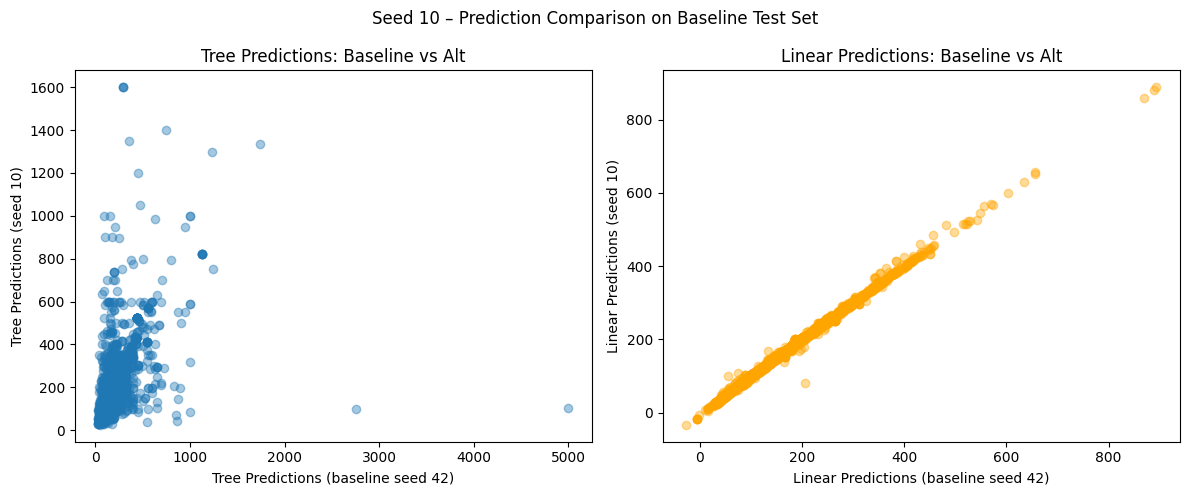

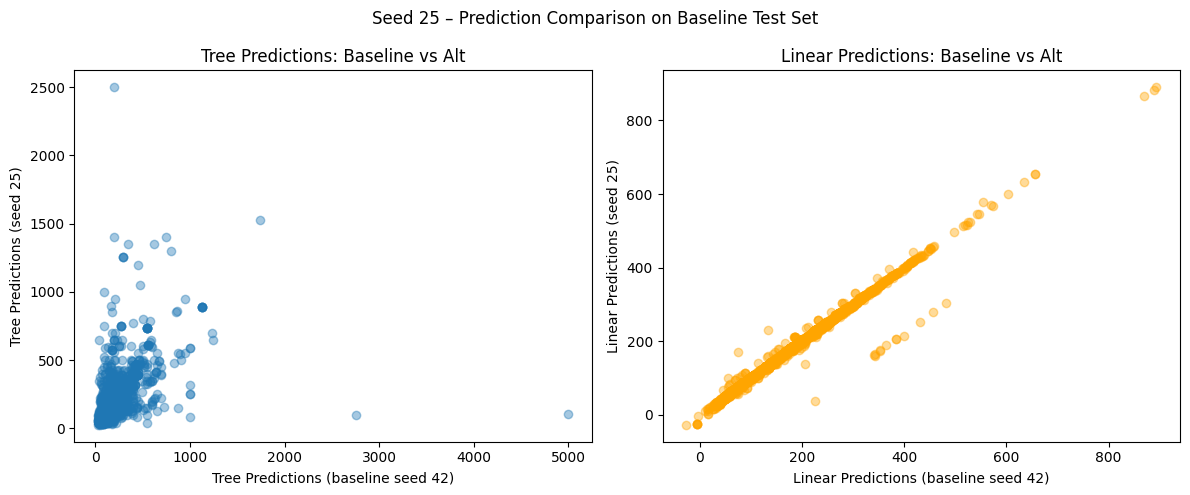

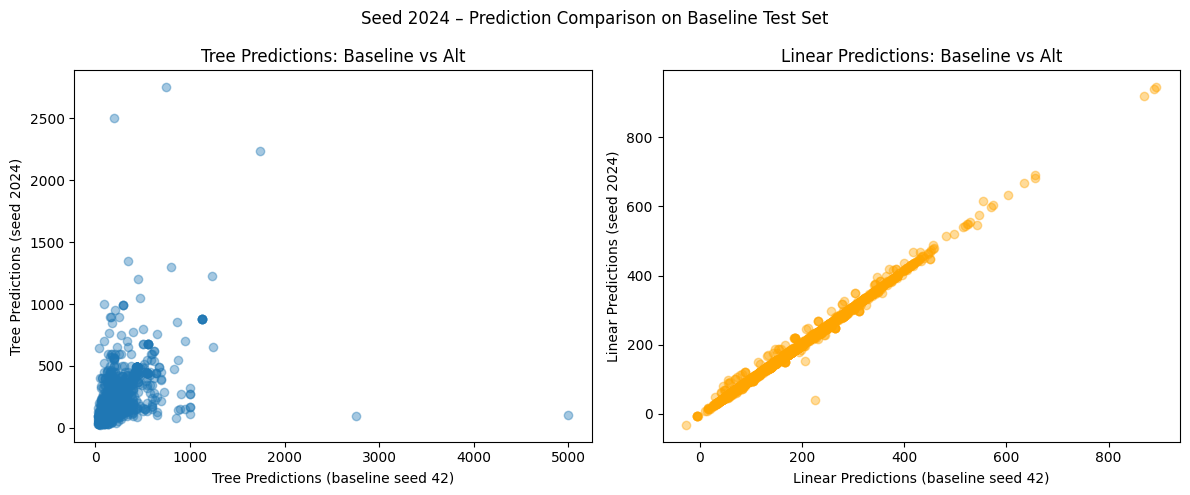

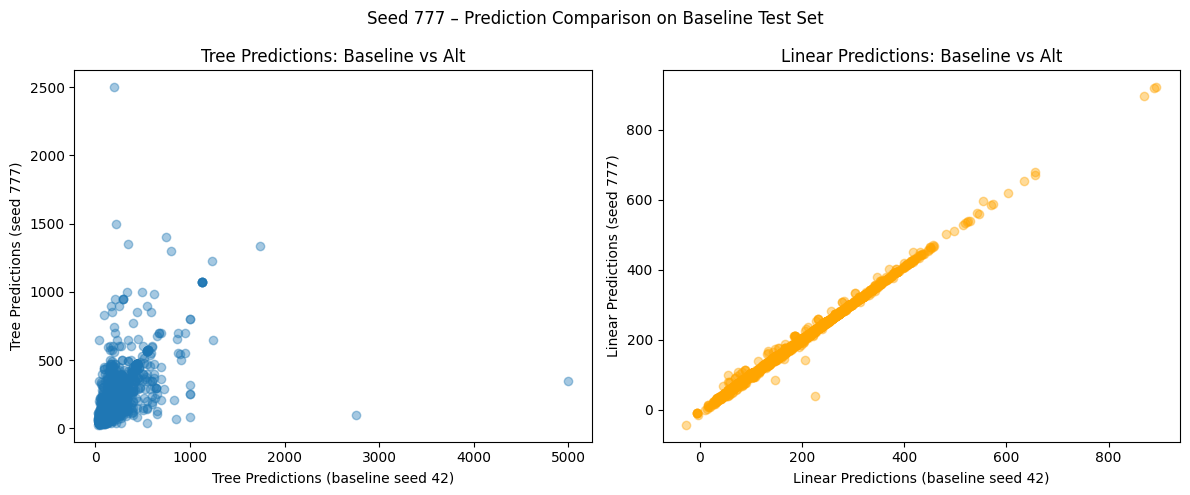

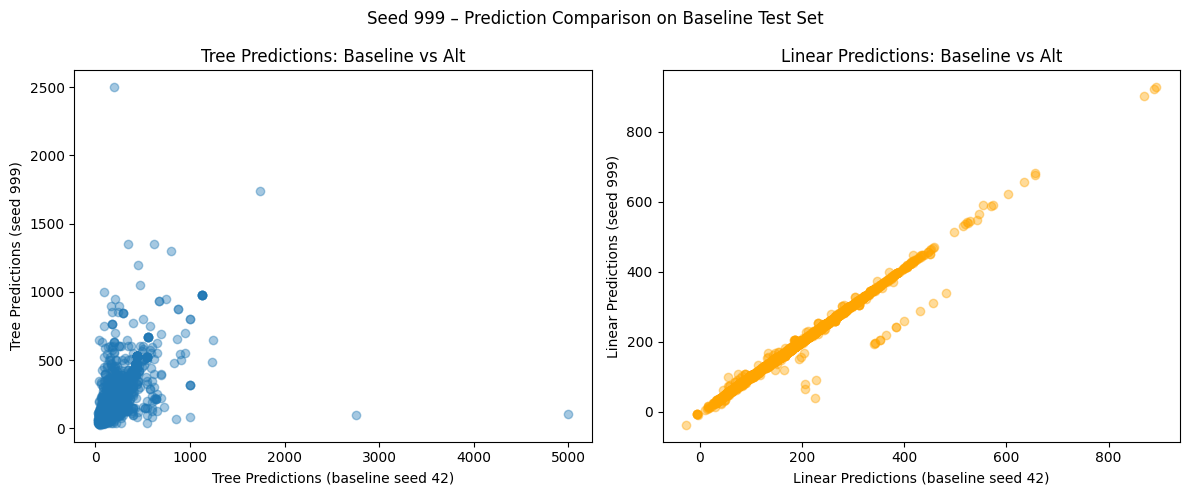

CORRELATIONS (baseline vs alt predictions on same test set)


,seed,tree_corr,linear_corr
0,10,0.638228,0.999146
1,25,0.637120,0.994741
2,2024,0.622274,0.998600
3,777,0.668276,0.998924
4,999,0.650096,0.995853


REGRESSION RESULTS (alt ~ baseline predictions)


,seed,tree_slope,tree_intercept,tree_r2,linear_slope,linear_intercept,linear_r2
0,10,0.570526,71.395237,0.407335,1.007778,-0.387893,0.998293
1,25,0.584916,68.524027,0.405922,0.993056,2.028350,0.989510
2,2024,0.577194,69.403622,0.387225,1.037485,-4.675849,0.997202
3,777,0.607425,64.405629,0.446593,1.028040,-3.812683,0.997849
4,999,0.598918,66.478580,0.422625,1.017535,-1.983715,0.991722


In [7]:
# Q4: Compare predictions

import matplotlib.pyplot as plt

corr_results = []
reg_results = []

base_tree = tree_pred_base
base_lin = lin_pred_base

for seed in alt_seeds:
    alt_tree = alt_preds_on_base[seed]["tree"]
    alt_lin = alt_preds_on_base[seed]["linear"]

    # Scatterplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Seed {seed} – Prediction Comparison on Baseline Test Set")

    # Tree scatter
    ax[0].scatter(base_tree, alt_tree, alpha=0.4)
    ax[0].set_title("Tree Predictions: Baseline vs Alt")
    ax[0].set_xlabel("Tree Predictions (baseline seed 42)")
    ax[0].set_ylabel(f"Tree Predictions (seed {seed})")

    # Linear scatter
    ax[1].scatter(base_lin, alt_lin, alpha=0.4, color="orange")
    ax[1].set_title("Linear Predictions: Baseline vs Alt")
    ax[1].set_xlabel("Linear Predictions (baseline seed 42)")
    ax[1].set_ylabel(f"Linear Predictions (seed {seed})")

    plt.tight_layout()
    plt.show()

    # Correlations
    corr_tree = np.corrcoef(base_tree, alt_tree)[0, 1]
    corr_lin  = np.corrcoef(base_lin,  alt_lin )[0, 1]

    corr_results.append({
        "seed": seed,
        "tree_corr": corr_tree,
        "linear_corr": corr_lin
    })

    # Simple linear regression
    # Tree regression
    reg_tree = LinearRegression().fit(base_tree.reshape(-1, 1), alt_tree)
    slope_tree = reg_tree.coef_[0]
    intercept_tree = reg_tree.intercept_
    r2_tree = reg_tree.score(base_tree.reshape(-1, 1), alt_tree)

    # Linear regression predictions
    reg_lin = LinearRegression().fit(base_lin.reshape(-1, 1), alt_lin)
    slope_lin = reg_lin.coef_[0]
    intercept_lin = reg_lin.intercept_
    r2_lin = reg_lin.score(base_lin.reshape(-1, 1), alt_lin)

    reg_results.append({
        "seed": seed,
        "tree_slope": slope_tree,
        "tree_intercept": intercept_tree,
        "tree_r2": r2_tree,
        "linear_slope": slope_lin,
        "linear_intercept": intercept_lin,
        "linear_r2": r2_lin
    })

corr_df = pd.DataFrame(corr_results)
reg_df  = pd.DataFrame(reg_results)

print("CORRELATIONS (baseline vs alt predictions on same test set)")
display(corr_df)

print("REGRESSION RESULTS (alt ~ baseline predictions)")
display(reg_df)

The scatterplots show very different patterns for trees and linear models. The tree plots form a wide cloud with only a loose upward trend, so the alternative trees do not closely match the baseline tree predictions. The linear plots fall almost exactly along a straight line, so the alternative linear models give predictions that look very similar to the baseline linear model.

The numerical diagnostics support this visual impression. The tree correlations with the baseline tree are only moderate, between about 0.62 and 0.67, and the tree regressions have slopes around 0.57–0.61, intercepts around 64–71, and R² values only about 0.39–0.45, so the tree predictions differ substantially across seeds. The linear correlations with the baseline linear model are extremely high, between about 0.995 and 0.999, and the linear regressions have slopes very close to 1, intercepts close to 0, and R² values near 1, so the linear model predictions are almost identical across different train/test splits.

In [ ]:
# Q5: Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?

Yes. The linear models have very similar coefficients and predictions across all train/test splits. The signs and relative magnitudes of the coefficients stay almost the same, and the predictions are extremely close, with correlations around 0.99 and regression slopes near 1. This pattern shows that the linear model is stable: small changes in the training data do not meaningfully change the fitted model or its predictions.

The trees are less stable. Their test-set R² values vary from about
−0.14 to about 0.13, and their predictions only have moderate correlation with the baseline tree (around 0.63–0.67), with regression slopes around 0.57–0.61. These results show that different train/test splits can lead to noticeably different tree structures and different predictions.

In [ ]:
# Q6: True or false, and explain

The statement is generally true for linear models, but only partly true for trees. For linear regression, different train/test splits give models that may look slightly different in their coefficients, but the predictions are almost identical: the scatterplots line up on a straight line, the correlation is very close to 1, and the regression of alternative predictions on baseline predictions has slope ≈ 1 and R² ≈ 1.

For decision trees, the models often look very different and their predictions are only moderately similar. The trees choose different splits and depths, and although their predictions are positively correlated with the baseline tree, the correlations and R² values are far from 1 and the slopes are well below 1. So for trees, a substantially different appearance usually does go along with noticeably different predictions.